Thanks @tmoroder.  
<a href='https://www.kaggle.com/code/morodertobias/hull-leak-safe-baseline'>https://www.kaggle.com/code/morodertobias/hull-leak-safe-baseline</a>

I replaced ElasticNet with Ridge, Lasso, or LinearRegression, only for teaching purposes. 
From version 9, the model has not been leaked, but it is not very stable.

v1:ridge

v2:LinearRegression

v3:Lasso

v4-v5:Lasso, parameter tuning

v6:Lasso, Printing selected features

v7:Lasso, Based on all features.

v8:Lasso, Add cross-feature interactions.

v9:Lasso, TimeSeriesSplit.

v10:Lasso, Keep only recent data.

v11:Lasso, parameter tuning.

## Import & Settings

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import polars as pl 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import plotly as py
init_notebook_mode(connected=True) 
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV 

from sklearn.preprocessing import StandardScaler
import kaggle_evaluation.default_inference_server
from metric import score as hull_score

import warnings
warnings.simplefilter('ignore')

In [2]:
BASE_DIR = pathlib.Path("/kaggle/input/hull-tactical-market-prediction")
SEED = 42
TEST_SKIP = 180
# same features as in hull starter nb
'''
FEATURES = [
    "S2",
    "E2", "E3",
    "P8", "P9", "P10", "P12", "P13",
    "S1", "S5", 
    "I2",
    "U1",
    "U2",
]
'''

INFO_COLS = ["date_id", "forward_returns", "risk_free_rate"]
# model as in hull starter
CV = 10
L1_RATIO = 0.5
#ALPHAS = np.linspace(0.0001, 10, 5)
ALPHAS = [0.013]
MAX_ITER = 1000000

## Load data

In [3]:
data = pd.read_csv(BASE_DIR / "train.csv")
data = data.iloc[8500:]
data["U1"] = data["I2"] - data["I1"]
data["U2"] = data["M11"] / ((data["I2"] + data["I9"] + data["I7"]) / 3)

FEATURES = [col for col in data.columns if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]
data = data[FEATURES + INFO_COLS].dropna()
data

,D1,D2,D3,D4,D5,D6,D7,D8,D9,E1,...,V5,V6,V7,V8,V9,U1,U2,date_id,forward_returns,risk_free_rate
8500,0,0,0,0,1,0,0,1,0,1.366055,...,0.301477,0.951720,-0.367162,0.050926,-0.540809,1.678277,0.214509,8500,-0.002427,0.000211
8501,0,0,0,0,1,0,0,1,0,1.364795,...,0.133827,0.955026,-0.345932,0.046627,-0.523585,1.684799,0.186157,8501,-0.000398,0.000210
8502,0,0,0,0,1,0,0,0,1,1.363541,...,0.223866,0.888889,-0.335729,0.041667,-0.509141,1.629998,0.183808,8502,-0.013386,0.000211
8503,0,0,0,0,1,0,0,0,1,1.362292,...,-0.246693,0.932540,-0.071269,0.029101,-0.262419,1.736953,0.276440,8503,0.007282,0.000212
8504,0,0,0,0,0,0,0,0,1,1.361050,...,-0.192648,0.880291,-0.218937,0.015873,-0.386440,1.917704,0.303851,8504,-0.000377,0.000212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8985,0,0,0,0,0,0,0,0,0,1.565379,...,1.226772,0.822751,-0.707361,0.142857,-0.649616,0.709975,-0.418763,8985,0.002457,0.000155
8986,0,0,0,0,0,0,0,0,0,1.562946,...,0.785877,0.805556,-0.715692,0.196098,-0.668289,0.634612,-0.364351,8986,0.002312,0.000156
8987,0,0,1,0,0,0,0,0,0,1.560520,...,0.834898,0.823413,-0.723949,0.133929,-0.670946,0.569147,-0.252353,8987,0.002891,0.000156
8988,0,0,0,0,0,0,0,0,0,1.558102,...,0.994026,0.851852,-0.684937,0.101852,-0.646265,0.585764,-0.201990,8988,0.008310,0.000156


In [4]:
max_train_date = data["date_id"].max() - TEST_SKIP
print("max train date_id:", max_train_date)

max train date_id: 8809


In [5]:
train = data.loc[data["date_id"] <= max_train_date].copy()
test = data.loc[data["date_id"] > max_train_date].copy()
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (310, 99)
test shape: (180, 99)


In [6]:
def add_feature_cross_terms(df, numerical_features):
    df_new = df.copy()
    
    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]

    return df_new

train = add_feature_cross_terms(train, FEATURES)
test = add_feature_cross_terms(test, FEATURES)
print(train.shape)
FEATURES = [col for col in train.columns if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]

(310, 4659)


## Build target
Set target as best strategy on training dataset.

In [7]:
solution = train.copy()
market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
market_excess_cumulative = (1 + market_excess_returns).prod()
market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1
c = (1 + market_mean_excess_return) ** (1 / (market_excess_returns > 0).mean()) - 1
submission = pd.DataFrame({'prediction': (c / market_excess_returns).clip(0, 2)})
print("best score train:", hull_score(solution, submission, ''))

best score train: 17.767744047269257


In [8]:
train["target"] = submission

In [9]:
fig = go.Figure(data=[go.Scatter3d(
    x=train['forward_returns'],
    y=train['risk_free_rate'],
    z=train['target'],
    mode='markers',
    marker=dict(size=3)
)])
fig.update_layout(
    scene=dict(
        xaxis_title='forward_returns',
        yaxis_title='risk_free_rate',
        zaxis_title='target'
    )
)
iplot(fig)

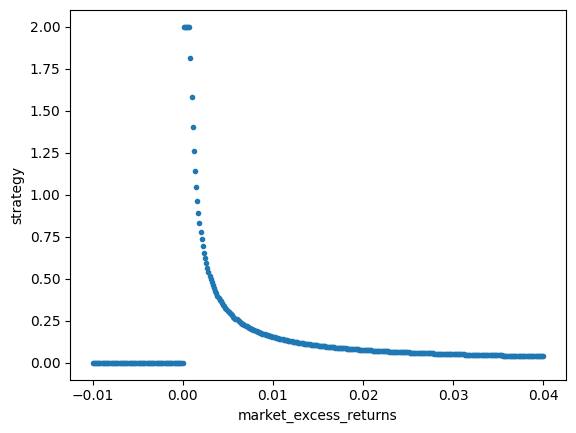

In [10]:
market_excess_returns = np.linspace(-0.01, 0.04, 402)
plt.plot(market_excess_returns, (c / market_excess_returns).clip(0, 2), '.')
plt.xlabel("market_excess_returns")
plt.ylabel("strategy")
plt.show()

## Model

In [11]:
X_train = train[FEATURES].values
y_train = train["target"].values
print(X_train.shape)

(310, 4656)


In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = sc.fit_transform(X_train)

#model_cv = ElasticNetCV(l1_ratio=L1_RATIO, cv=CV, alphas=ALPHAS, max_iter=MAX_ITER)
#model_cv.fit(X_train_scaled, y_train)
#model = ElasticNet(alpha=model_cv.alpha_, l1_ratio=L1_RATIO)
#model.fit(X_train_scaled, y_train)

from sklearn.model_selection import TimeSeriesSplit
# 定义时间序列交叉验证器
tscv = TimeSeriesSplit(n_splits=CV)  # CV 通常是 5 或 10
# 使用 TimeSeriesSplit 进行 LassoCV
model_cv = LassoCV(
    alphas=ALPHAS,
    cv=tscv,                    # ✅ 关键：使用时间序列 CV
    max_iter=MAX_ITER,
    random_state=SEED,
    n_jobs=-1                   # 可选：并行加速（注意：TimeSeriesSplit 支持有限）
)

model_cv.fit(X_train_scaled, y_train)
model = Lasso(alpha=model_cv.alpha_, max_iter=MAX_ITER)
model.fit(X_train_scaled, y_train)

print("Selected alpha:", model_cv.alpha_)
print("Number of non-zero coefficients:", np.count_nonzero(model.coef_))
print("Coefficients:", model.coef_)

Selected alpha: 0.013
Number of non-zero coefficients: 10
Coefficients: [-0. -0. -0. ... -0.  0.  0.]


In [13]:
# 构建成DataFrame便于分析和排序
feature_importance_df = pd.DataFrame({
    'feature': FEATURES,
    'coefficient': model.coef_
}).sort_values(by='coefficient', key=abs, ascending=False)  # 按绝对值排序

# 只显示非零特征
selected_features_df = feature_importance_df[feature_importance_df['coefficient'] != 0]

print("Selected Features (sorted by importance):")
print(selected_features_df)

Selected Features (sorted by importance):
        feature  coefficient
4575   V10_x_V9     0.213719
489     D5_x_E5    -0.057490
1521  E16_x_M13     0.052911
1175  E12_x_E18     0.046561
4114   P3_x_V10    -0.039470
379     D4_x_D6    -0.039447
427     D4_x_M7     0.038855
386    D4_x_E12    -0.025061
1043   E10_x_M7     0.021545
7            D8    -0.004913


In [14]:
model.score(X_train_scaled, y_train)

0.05494311535144625

## Invoke on test set

In [15]:
X_test = test[FEATURES].values
X_test_scaled = sc.transform(X_test)
y_test_pred = model.predict(X_test_scaled)
y_test_pred = np.clip(y_test_pred, 0.0, 2.0)
pd.Series(y_test_pred).describe()

count    180.000000
mean       0.322376
std        0.074477
min        0.237398
25%        0.287279
50%        0.309233
75%        0.331930
max        0.947888
dtype: float64

In [16]:
solution = test.copy()
submission = pd.DataFrame({'prediction': y_test_pred}, index=solution.index)
print("score public test:", hull_score(solution, submission, ''))

score public test: 0.787458392469568


# Submit

In [17]:
def predict(test: pl.DataFrame) -> float:
    data = test.to_pandas()
    data["U1"] = data["I2"] - data["I1"]
    data["U2"] = data["M11"] / ((data["I2"] + data["I9"] + data["I7"]) / 3) 
    test_col = [col for col in data.columns if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns','is_scored']]
    data = add_feature_cross_terms(data, test_col)
    X = data[FEATURES].values
    X_scaled = sc.transform(X)
    y = model.predict(X_scaled)
    pred = np.clip(y, 0.0, 2.0)[0]
    print(f"date_id: {data['date_id'][0]} -> prediction: {pred:>.4f}")
    return pred

In [18]:
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway((BASE_DIR.as_posix(),))

date_id: 8980 -> prediction: 0.3243
date_id: 8981 -> prediction: 0.3193
date_id: 8982 -> prediction: 0.2731
date_id: 8983 -> prediction: 0.2949
date_id: 8984 -> prediction: 0.3217
date_id: 8985 -> prediction: 0.3152
date_id: 8986 -> prediction: 0.3218
date_id: 8987 -> prediction: 0.3319
date_id: 8988 -> prediction: 0.3197
date_id: 8989 -> prediction: 0.3326
